# Supply Visualization Class

## Import packages

In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree
import imageio
from datetime import datetime
from pytz import timezone
import pytz
import pickle #TEST

## Class implementation

In [2]:
class GHIVisualization():
    def __init__(self, year: str):
        assert isinstance(year, str) and len(year) == 4, f'year should be a four digits string. e.g \'2018\''
        self.year = year
        
    def load_data(self):
        '''
        Load NSRDB dataset from https://data.openei.org/s3_viewer?bucket=nrel-pds-nsrdb&prefix=v3%2F
        Returns:
            f (h5pyd file): NSRDB file
            meta (pandas.DataFrame): Contains information of every state
            time_index (pandas.DataFrame): Time index for the year
            coords (numpy.ndarray): The whole coordinates in the dataset
        '''
        path = f"/nrel/nsrdb/v3/nsrdb_{self.year}.h5"
        print(f'Loading {self.year} NSRDB dataset...')
        f = h5pyd.File(path, 'r')
        print(f'Successfully loading {self.year} NSRDB dataset!')
        
        # Get time index
        time_index = pd.to_datetime(f['time_index'][:].astype(str))
        print(f'Successfully loading time index dataset!')
        
        # Get every coordinates of the dataset
        coords = f['coordinates'][:]
        print(f'Successfully loading coordinates dataset!')
        
        # Full resolution subset
        print(f"Loading meta data...")
        meta = pd.DataFrame(f['meta'][:])
        print(f'Successfully loading meta dataset!')
        
        return f, meta, time_index, coords
    
    def load_state_data(self, f, meta, state_name):
        '''
        Load the given state data from the NSRDB file
        Args:
            f (h5pyd): nsrdb file
            meta (pandas.DataFrame): Contains information of every state
            state_name (string): state name e.g. 'California'
        Returns:
            state_data (pandas.DataFrame): the dataset of the state
            state_tseries: the whold time series of the state
        '''
        # Check if the given state name is in the dataset
        if state_name.encode('ASCII') not in meta['state'].unique():
            raise KeyError(f'{state_name} is not in {f}. Check with: state_name.encode(\'ASCII\') in meta[\'state\'].unique()')
        
        print(f"Loading {state_name} data...")
        state_data = meta.loc[meta['state'] == state_name.encode('ASCII')] # Note .h5 saves strings as bit-strings
        print(f"Done!")
        
        # Get the index of the state coordinates in coords
        state_index = np.array(state_data.index)
        
        # Get the sum of GHI of the state (get one coordinate every 10)
        print(f'Loading the whole state time series...')
        state_tseries = np.sum(f['ghi'][:, state_index[::10]] / f['ghi'].attrs['psm_scale_factor'], axis=1)
        print(f'Done!')
        
        #TEST start
        global stateName
        stateName = state_name
        #TEST end
        
        return state_data, state_tseries
        
    def plot_all_ghi_heatmap(self, f, timestamp, coords, file_name=None, save=False):
        '''
        Plot the GHI of the whold coordinates in the dataset at a certain timestamp
        Args:
            f (h5pyd): nsrdb file
            timestamp (string): certain time (UTC) to plot, need to be the same year as the input file f. e.g '2018-12-24 12:00:00'
            coords (numpy.ndarray): coordiantes in the dataset. (coords = f['coordinates'][:])
            data (numpy.ndarray): GHI of every coordinates at the timestamp (data = f['ghi'][timestep, ::10]   # extract ghi for every 10th location at a particular time)
            file_name (string): file name to save the plotted figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            df (pandas.DataFrame): the dataframe contains longitude, latitude and GHI
        '''
        assert timestamp.split(' ')[0].split('-')[0] == self.year, f'Need to use the same year as the load file'
        
        # Get time index for that year
        time_index = pd.to_datetime(f['time_index'][...].astype(str))
        
        # Get the index of given timestamp
        timestep = np.where(time_index == timestamp)[0][0]
        
        # Get all ghi data
        print(f'Getting all GHI values...')
        all_ghi = f['ghi'][timestep, ::10]
        print(f'Done!')
        
        # Combine data (GHI) with coordinates into a DataFrame
        df = pd.DataFrame() 
        df['longitude'] = coords[::10, 1]
        df['latitude'] = coords[::10, 0]
        df['ghi'] = all_ghi / f['ghi'].attrs['psm_scale_factor'] # unscale dataset
        
        df.plot.scatter(x='longitude', y='latitude', c='ghi',
            #colormap='YlOrRd', #arbera revert
            title=str(time_index[timestep]) + ' UTC')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        print(f'GHI at {str(time_index[timestep])} UTC')
        plt.show()
        
        #TEST start
        global allGhiHeatmap
        allGhiHeatmap = 1
        #TEST end
        
        return df
        
    def plot_state_ghi_heatmap(self, f, timestamp, state_data, file_name=None, save=False):
        '''
        Plot the heatmap of the GHI of given state at a certain timestamp
        Args:
            f (h5pyd): nsrdb file
            timestamp (string): certain time (UTC) to plot. e.g '2018-12-24 14:00:00'
            state_data (pandas.DataFrame): state data from load_state_data()
            file_name (string): file name to save the plotted figure
            save (boolean): True to save, False otherwise. (Default False)
        Return:
            df (pandas.DataFrame): A pandas.DataFrame contains the info of the state and GHI
        '''
        assert timestamp.split(' ')[0].split('-')[0] == self.year, f'Need to use the same year as the load file.'
        if save:
            assert file_name != None, f'Need file name for saving.'
        
        # Get time index for that year
        time_index = pd.to_datetime(f['time_index'][...].astype(str))
        
        # Get the index of given timestamp
        timestamp_index = np.where(time_index == timestamp)[0][0]
        
        # Get the GHI of the state at the given timestamp
        print(f'Loading GHI...')
        state_ghi = f['ghi'][timestamp_index][state_data.index]  # full-resolution subset
        print(f'Done!')
        
        # Get the longitude and latitude of the state at the given timestamp
        df = state_data[['longitude', 'latitude', 'country', 'state', 'county']].copy()
        
        # Get the GHI of every coordinates (longitude, latitude) in the state
        df['ghi'] = state_ghi / f['ghi'].attrs['psm_scale_factor'] 
        
        # Plot the map
        df.plot.scatter(x='longitude', y='latitude', c='ghi',
                    #colormap='YlOrRd', #arbera revert
                    title=str(time_index[timestamp_index]) + ' UTC')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        #TEST start
        global stateGhiHeatmap
        stateGhiHeatmap = 1
        #TEST end

        return df
            
    def plot_one_coord_ghi(self, f, state_name, coords, lat_coord, lon_coord, file_name=None, save=False):
        '''
        Plot the ghi of the given latitude and longitude
        Args:
            f (h5pyd): nsrdb file
            state_name (string): to print in the figure
            coords: coordinates of the dataset
            lat_coord: given latitude
            lon_coord: given longitude
        Returns:
            df (pandas.DataFrame): A pandas.DataFrame contains the info of the timestamp and GHI
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
            
        tree = cKDTree(coords)
        def nearest_site(tree, lat_coord, lon_coord):
            lat_lon = np.array([lat_coord, lon_coord])
            dist, pos = tree.query(lat_lon)
            return pos

        coord = (lat_coord, lon_coord)
        # Get the nearest state index in coords
        state_idx = nearest_site(tree, coord[0], coord[1])

        print("Site index: \t\t {}".format(state_idx))
        print("Input coordinates: \t {}".format(coord))
        print("Nearest coordinates: \t {}".format(coords[state_idx]))
        
        # Get the entire 2018 timeseries data for a point in San Diego (Skip one every two to get match the demand dataset)
        tseries = f['ghi'][:, state_idx] / f['ghi'].attrs['psm_scale_factor']
        
        # Plot the ghi across the year in given coordinate
        #plt.plot(time_index[:], tseries)
        plt.plot(np.array(time_index[:]), np.array(tseries)) #arbera revert
        plt.ylabel("GHI (W/m2)")
        plt.title(f"{state_name} GHI in {self.year}")
        if save:
            plt.savefig(file_name)
        
        df = pd.DataFrame({'Time':time_index[::1], 'GHI': tseries})
        
        #TEST start
        global oneCoordGhi
        oneCoordGhi = 1
        
        global inputCoord
        inputCoord = coord
        
        global nearestCoord
        nearestCoord = coords[state_idx]
        #TEST end
        
        return df
    
    def plot_state_GHI_in_one_year(self, f, state_data, time_index, state_tseries, file_name=None, save=False):
        '''
        Plot the GHI of the given state in the given year
        Args:
            f (h5pyd): nsrdb file
            state_data (pandas.DataFrame): state data from load_state_data()
            time_index: time index from load_data()
            file_name (string): path to save the figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            pd.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        
        # Get state name
        state_name = list(state_data['state'])[0]
        state_name = str(state_name, encoding='utf-8')
        
        # Plot
        #plt.plot(time_index[:], state_tseries, '-')
        plt.plot(np.array(time_index[:]), np.array(state_tseries), '-') #arbera revert
        plt.ylabel("GHI (W)")
        plt.title(f"{state_name} GHI in {self.year}")
        file_name = f'{state_name}_GHI_in_{self.year}.jpg'
        
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        df = pd.DataFrame({'Time': time_index, 'GHI': state_tseries})
        
        #TEST start
        global stateGHIInOneYear
        stateGHIInOneYear = 1
        #TEST end
        
        return df
    
    def plot_state_month_hour_heatmap(self, f, state_data, state_tseries, file_name=None, save=False):
        '''
        Plot month-hour heatmap for given state
        Args:
            f (h5pyd): nsrdb file
            state_data (pandas.DataFrame): state data from load_state_data()
            state_tseries (array): sum of GHI of the state from load_state_data()
            file_name (string): path to save the figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            pd.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        # Get the coordinates of the state
        df = state_data[['longitude', 'latitude']].copy()
        
        df = pd.DataFrame({'ghi': state_tseries}, index=time_index)
        df["year"] = df.index.year
        df["month"] = df.index.month
        df["day"] = df.index.day
        df["hour"] = df.index.hour
        
        # Get GHI by each hour and month
        agg = df.groupby(["month", "hour"]).mean()
        agg = agg.reset_index().pivot(index="month", columns='hour', values="ghi")
        
        # Get state name
        state_name = list(state_data['state'])[0]
        state_name = str(state_name, encoding='utf-8')
        
        # Plot the Heat Map
        plt.imshow(agg)
        plt.xlabel("Hour")
        plt.ylabel("Month")
        plt.title(f'{self.year} Mean GHI in {state_name} (W/m^2)')
        plt.colorbar()
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        #TEST start
        global stateMonthHourHeatmap
        stateMonthHourHeatmap = 1
        #TEST end
        
        return agg
    
    def plot_state_variance(self, f, state_data, state_tseries, file_name=None, save=False):
        '''
        Plot the GHI variance of the state
        Args:
            f (h5pyd): nsrdb file
            state_data (pandas.DataFrame): state data from load_state_data()
            state_tseries (array): sum of GHI of the state from load_state_data()
            file_name (string): path to save the figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            pd.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        # Get the coordinates of the state
        df = state_data[['longitude', 'latitude']].copy()
        
        df = pd.DataFrame({'ghi': state_tseries}, index=time_index)
        df["year"] = df.index.year
        df["month"] = df.index.month
        df["day"] = df.index.day
        df["hour"] = df.index.hour
        
        # Get the sum of GHI in a day for every month
        agg_sum = df.groupby(["month", "day"]).sum()
        agg_sum = agg_sum.reset_index().pivot(index="day",columns="month",values="ghi")
        
        # Get state name
        state_name = list(state_data['state'])[0]
        state_name = str(state_name, encoding='utf-8')
        
        # Get the boxplot
        plt.figure()
        agg_sum.boxplot(column=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        plt.title(f'Variation per month in GHI in {state_name} ({self.year})')
        plt.xlabel('Month')
        plt.ylabel('GHI (W/m2)')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        #TEST start
        global stateVariance
        stateVariance = 1
        #TEST end
            
        return agg_sum
    
    def plot_state_GHI_by_month(self, f, state_data, state_tseries, months, file_name=None, save=False):
        '''
        Plot the GHI by days of given months
        Args:
            f (h5pyd): nsrdb file
            state_data (pandas.DataFrame): state data from load_state_data()
            state_tseries (array): sum of GHI of the state from load_state_data()
            months (list(int)): months to plot, from 1 to 12. e.g [1, 2, 6, 7, 8, 12]
            file_name (string): path to save the figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            pd.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        # Get the coordinates of the state
        df = state_data[['longitude', 'latitude']].copy()
        
        df = pd.DataFrame({'ghi': state_tseries}, index=time_index)
        df["year"] = df.index.year
        df["month"] = df.index.month
        df["day"] = df.index.day
        df["hour"] = df.index.hour
        
        # Get the sum of GHI in a day for every month
        agg_sum = df.groupby(["month", "day"]).sum()
        agg_sum = agg_sum.reset_index().pivot(index="day",columns="month",values="ghi")
        
        # Get state name
        state_name = list(state_data['state'])[0]
        state_name = str(state_name, encoding='utf-8')
        
        # Plot
        plt.figure()
        agg_sum[months].plot(style='-')
        plt.title(f'Months GHI in {state_name} ({self.year})')
        plt.xlabel('Day')
        plt.ylabel('GHI (W/m2)')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
            
        #TEST start
        global stateGHIByMonth
        stateGHIByMonth = 1
        #TEST end
            
        return agg_sum[months]
        

In [3]:
s = GHIVisualization('2019')

In [4]:
s.year

'2019'

In [5]:
f, meta, time_index, coords = s.load_data()

Loading 2019 NSRDB dataset...
Successfully loading 2019 NSRDB dataset!
Successfully loading time index dataset!
Successfully loading coordinates dataset!
Loading meta data...
Successfully loading meta dataset!


In [6]:
#TEST start
global stateName_ref
stateName_ref = 'California'
california_data, california_tseries = s.load_state_data(f, meta, stateName_ref)
#TEST end

Loading California data...
Done!
Loading the whole state time series...
Done!


In [7]:
california_data

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
70276,32.529999,-117.099998,55.062500,-8,b'United States',b'California',b'San Diego',b'None',32326,130
70588,32.570000,-117.099998,7.100000,-8,b'United States',b'California',b'San Diego',b'Tijuana',27971,190
70589,32.570000,-117.059998,24.920000,-8,b'United States',b'California',b'San Diego',b'Tijuana',51608,190
70590,32.570000,-117.019997,96.599998,-8,b'United States',b'California',b'San Diego',b'Tijuana',15236,110
70591,32.570000,-116.980003,140.600006,-8,b'United States',b'California',b'San Diego',b'Tijuana',2949,130
...,...,...,...,...,...,...,...,...,...,...
172687,41.970001,-120.180000,2289.360107,-8,b'United States',b'California',b'Modoc',b'None',0,70
172688,41.970001,-120.139999,2276.080078,-8,b'United States',b'California',b'Modoc',b'None',0,70
172689,41.970001,-120.099998,2039.900024,-8,b'United States',b'California',b'Modoc',b'None',0,70
172690,41.970001,-120.059998,1775.760010,-8,b'United States',b'California',b'Modoc',b'None',0,70


In [8]:
# Sum of GHI through the year
california_tseries

array([217887.,  88144.,   3101., ..., 811856., 622017., 426110.])

In [9]:
time_index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 00:30:00',
               '2019-01-01 01:00:00', '2019-01-01 01:30:00',
               '2019-01-01 02:00:00', '2019-01-01 02:30:00',
               '2019-01-01 03:00:00', '2019-01-01 03:30:00',
               '2019-01-01 04:00:00', '2019-01-01 04:30:00',
               ...
               '2019-12-31 19:00:00', '2019-12-31 19:30:00',
               '2019-12-31 20:00:00', '2019-12-31 20:30:00',
               '2019-12-31 21:00:00', '2019-12-31 21:30:00',
               '2019-12-31 22:00:00', '2019-12-31 22:30:00',
               '2019-12-31 23:00:00', '2019-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17520, freq=None)

Getting all GHI values...
Done!
GHI at 2019-12-24 17:00:00 UTC


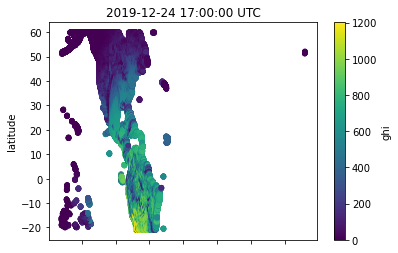

In [10]:
timestamp = '2019-12-24 17:00:00'
df_all_ghi_heatmap = s.plot_all_ghi_heatmap(f, timestamp, coords, file_name=None, save=False)

In [11]:
df_all_ghi_heatmap

,longitude,latitude,ghi
0,-175.259995,-19.990000,5.0
1,-174.860001,-19.990000,3.0
2,-174.179993,-19.990000,4.0
3,-158.139999,-19.990000,142.0
4,-157.740005,-19.990000,134.0
...,...,...,...
201835,179.740005,51.930000,8.0
201836,179.779999,52.009998,8.0
201837,179.779999,52.169998,8.0
201838,179.820007,51.689999,8.0


Loading GHI...
Done!


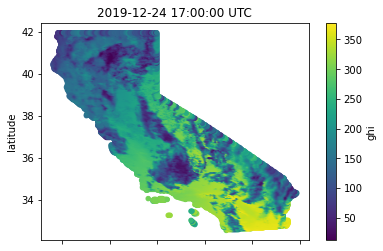

In [12]:
timestamp = '2019-12-24 17:00:00'
df_state_ghi_heatmap = s.plot_state_ghi_heatmap(f, timestamp, california_data, file_name=None, save=False)

In [13]:
df_state_ghi_heatmap

,longitude,latitude,country,state,county,ghi
70276,-117.099998,32.529999,b'United States',b'California',b'San Diego',309.0
70588,-117.099998,32.570000,b'United States',b'California',b'San Diego',283.0
70589,-117.059998,32.570000,b'United States',b'California',b'San Diego',344.0
70590,-117.019997,32.570000,b'United States',b'California',b'San Diego',346.0
70591,-116.980003,32.570000,b'United States',b'California',b'San Diego',347.0
...,...,...,...,...,...,...
172687,-120.180000,41.970001,b'United States',b'California',b'Modoc',85.0
172688,-120.139999,41.970001,b'United States',b'California',b'Modoc',129.0
172689,-120.099998,41.970001,b'United States',b'California',b'Modoc',155.0
172690,-120.059998,41.970001,b'United States',b'California',b'Modoc',80.0


Site index: 		 71886
Input coordinates: 	 (32.715736, -117.161087)
Nearest coordinates: 	 [  32.73 -117.18]


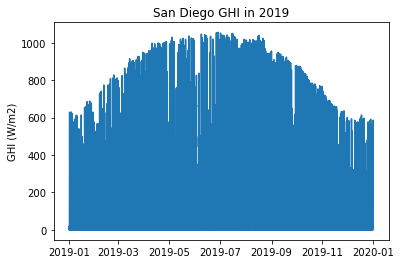

In [14]:
df_one_coord_ghi = s.plot_one_coord_ghi(f, 'San Diego', coords, 32.715736, -117.161087, file_name=None, save=False)

In [15]:
df_one_coord_ghi

,Time,GHI
0,2019-01-01 00:00:00,18.0
1,2019-01-01 00:30:00,10.0
2,2019-01-01 01:00:00,2.0
3,2019-01-01 01:30:00,0.0
4,2019-01-01 02:00:00,0.0
...,...,...
17515,2019-12-31 21:30:00,501.0
17516,2019-12-31 22:00:00,443.0
17517,2019-12-31 22:30:00,373.0
17518,2019-12-31 23:00:00,294.0


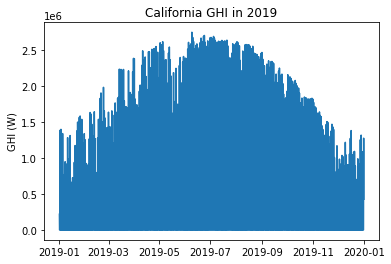

In [16]:
df_state_GHI_in_one_year = s.plot_state_GHI_in_one_year(f, california_data, time_index, california_tseries, file_name=None, save=False)

In [17]:
df_state_GHI_in_one_year

,Time,GHI
0,2019-01-01 00:00:00,217887.0
1,2019-01-01 00:30:00,88144.0
2,2019-01-01 01:00:00,3101.0
3,2019-01-01 01:30:00,0.0
4,2019-01-01 02:00:00,0.0
...,...,...
17515,2019-12-31 21:30:00,1096850.0
17516,2019-12-31 22:00:00,972289.0
17517,2019-12-31 22:30:00,811856.0
17518,2019-12-31 23:00:00,622017.0


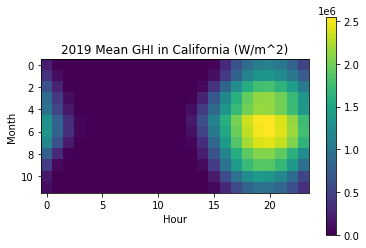

In [18]:
df_state_month_hour_heatmap = s.plot_state_month_hour_heatmap(f, california_data, california_tseries, file_name=None, save=False)

In [19]:
df_state_month_hour_heatmap

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,2.014867e+05,12492.483871,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,6.209677,4.474432e+04,2.929483e+05,6.277038e+05,9.095188e+05,1.078419e+06,1.112089e+06,1.016734e+06,8.096953e+05,5.188182e+05
2,3.769820e+05,81914.642857,212.446429,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,2081.928571,1.016494e+05,4.201960e+05,8.102499e+05,1.130205e+06,1.319377e+06,1.346323e+06,1.225508e+06,1.023711e+06,7.272954e+05
3,6.367886e+05,240199.451613,16133.112903,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,59457.483871,3.729165e+05,8.185263e+05,1.245645e+06,1.577624e+06,1.765986e+06,1.792593e+06,1.649351e+06,1.412125e+06,1.063059e+06
4,8.855915e+05,426108.216667,84567.183333,537.666667,0.000000,0.0,0.0,0.0,0.0,0.0,...,250419.383333,7.050753e+05,1.191561e+06,1.615955e+06,1.941958e+06,2.118403e+06,2.132475e+06,1.989552e+06,1.715300e+06,1.338264e+06
5,9.553286e+05,526747.822581,170049.403226,9480.854839,0.000000,0.0,0.0,0.0,0.0,0.0,...,441451.225806,8.928955e+05,1.336472e+06,1.722438e+06,1.999153e+06,2.147335e+06,2.133822e+06,1.993745e+06,1.736208e+06,1.380676e+06
6,1.273448e+06,783557.683333,328955.900000,44807.316667,3.283333,0.0,0.0,0.0,0.0,0.0,...,603372.433333,1.113478e+06,1.597394e+06,2.026721e+06,2.347168e+06,2.527274e+06,2.544057e+06,2.409825e+06,2.136581e+06,1.748690e+06
7,1.324530e+06,822777.903226,345572.951613,43421.758065,1.354839,0.0,0.0,0.0,0.0,0.0,...,519155.129032,1.027152e+06,1.529704e+06,1.972839e+06,2.304797e+06,2.499412e+06,2.535570e+06,2.415724e+06,2.156798e+06,1.781404e+06
8,1.177514e+06,650641.096774,188752.758065,7008.951613,0.000000,0.0,0.0,0.0,0.0,0.0,...,330348.500000,8.565018e+05,1.398654e+06,1.859309e+06,2.201966e+06,2.402246e+06,2.439476e+06,2.316230e+06,2.048520e+06,1.655631e+06
9,7.823099e+05,306531.733333,27655.816667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,189443.950000,6.514143e+05,1.149834e+06,1.585065e+06,1.903970e+06,2.069987e+06,2.075311e+06,1.922929e+06,1.638627e+06,1.243379e+06


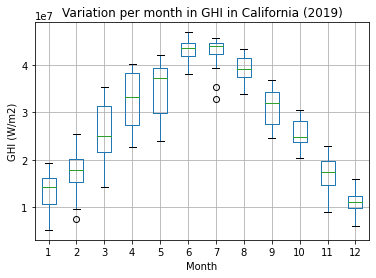

In [20]:
df_state_variance = s.plot_state_variance(f, california_data, california_tseries, file_name=None, save=False)

In [21]:
df_state_variance

month,1,2,3,4,5,6,7,8,9,10,11,12
day,,,,,,,,,,,,
1,16034858.0,11477004.0,18247619.0,26510591.0,41304770.0,39286472.0,45634509.0,43290746.0,36892755.0,30509931.0,22844115.0,9118401.0
2,16342451.0,7455638.0,15159848.0,24439594.0,41140659.0,38019756.0,45752049.0,43124834.0,32887643.0,30313129.0,21735286.0,11091235.0
3,14987447.0,10997632.0,19483044.0,26177438.0,41184850.0,41334585.0,44743561.0,41584189.0,34569638.0,29517286.0,21801141.0,10355043.0
4,15534479.0,11125080.0,21905906.0,24171647.0,42025606.0,43685104.0,45618834.0,41704054.0,32846654.0,29837328.0,21654170.0,5967310.0
5,5220233.0,15432016.0,14214269.0,22776605.0,39916467.0,43472136.0,45311941.0,39075307.0,27604690.0,29576122.0,20653269.0,11911900.0
6,8741393.0,20038607.0,15122565.0,27864585.0,36079894.0,41752028.0,44575689.0,33952622.0,34422714.0,29089138.0,20251444.0,11382883.0
7,10893204.0,20178004.0,20966953.0,29326863.0,37337366.0,44101982.0,40447764.0,36111847.0,32697932.0,28119885.0,19722331.0,7355093.0
8,10354980.0,17886893.0,23686458.0,25634344.0,37940778.0,46882240.0,43655921.0,39957815.0,35276435.0,27106196.0,20558867.0,10452993.0
9,10549222.0,14974663.0,21348308.0,32831673.0,33361358.0,45507439.0,42228852.0,38188635.0,33860067.0,28397656.0,19856334.0,14326573.0


<Figure size 432x288 with 0 Axes>

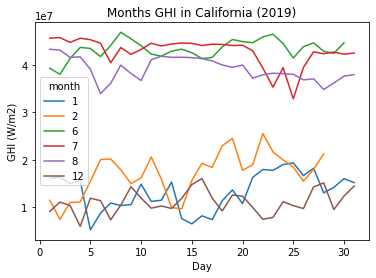

In [22]:
months = [1, 2, 6, 7, 8, 12]
df_state_GHI_by_month = s.plot_state_GHI_by_month(f, california_data, california_tseries, months, file_name=None, save=False)

In [23]:
df_state_GHI_by_month

month,1,2,6,7,8,12
day,,,,,,
1,16034858.0,11477004.0,39286472.0,45634509.0,43290746.0,9118401.0
2,16342451.0,7455638.0,38019756.0,45752049.0,43124834.0,11091235.0
3,14987447.0,10997632.0,41334585.0,44743561.0,41584189.0,10355043.0
4,15534479.0,11125080.0,43685104.0,45618834.0,41704054.0,5967310.0
5,5220233.0,15432016.0,43472136.0,45311941.0,39075307.0,11911900.0
6,8741393.0,20038607.0,41752028.0,44575689.0,33952622.0,11382883.0
7,10893204.0,20178004.0,44101982.0,40447764.0,36111847.0,7355093.0
8,10354980.0,17886893.0,46882240.0,43655921.0,39957815.0,10452993.0
9,10549222.0,14974663.0,45507439.0,42228852.0,38188635.0,14326573.0


In [24]:
#TEST start
with open('supplyVars.pkl', 'wb') as f:
    pickle.dump([stateName, stateName_ref, allGhiHeatmap, stateGhiHeatmap,
                 oneCoordGhi, stateGHIInOneYear, stateMonthHourHeatmap,
                 stateVariance, stateGHIByMonth, inputCoord, nearestCoord], f)
#TEST end

# Demand Visualization Class

## Import packages

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle #TEST

## Class implementation

In [26]:
class DemandVisualization():
    '''
    The class for energy demand visualization for given electrical data

    Parameter
    ---------
    energyDataFile: str
        Electrical demand data file path
    '''
    def __init__(self, energyDataFile: str='../raw_data/CAISOactualLoad.csv') -> None:
        assert isinstance(energyDataFile, str)

        self.demandData = pd.read_csv(energyDataFile)
        self.__energyDemand()

    def __energyDemand(self) -> pd.DataFrame:
        '''
        Calculate the demand with electrical data

        Returns
        -------
        zone	Year_Month	Year	Month	Day	Hour
        pandas.DataFrame
            | Date | Demand | zone | Year_Month | Year | Month | Day |
            |------|--------|------|------------|------|-------|-----|
        
            Date: datetime
            Demand: float
            zone: str
            Year_Month: str
            Year: int
            Month: int
            Day: int
        '''
        #TEST start
        global zoneCheck_ref
        zoneCheck_ref = 'CA ISO'
        df = self.demandData.loc[self.demandData['zone'] == zoneCheck_ref]

        global zoneCheck
        zoneCheck = df['zone'].iloc[0]
        #TEST end
        
        # Pre-process the data
        date_and_time = df['Date'].to_list()
        date = [d.split(' ') for d in date_and_time]
        for d in date:
            if d[2] == 'AM' and d[1] == '12:00:00':
                d[1] = '0:00:00'
            if d[2] == 'PM' and d[1] != '12:00:00':
                c = int(d[1].split(":")[0])
                d[1] = str(c + 12) + ":00:00"
        
        year_month = [d[0].split('/')[0] + '/' + d[0].split('/')[2] for d in date]
        year = [int(d[0].split('/')[2]) for d in date]
        month = [int(d[0].split('/')[0]) for d in date]
        day = [int(d[0].split('/')[1]) for d in date]
        hour = [int(d[1].split(':')[0]) for d in date]
        df['Year_Month'] = year_month
        df['Year'] = year
        df['Month'] = month
        df['Day'] = day
        df['Hour'] = hour
        self.__demandDF = df.rename(columns={'load': 'Demand'})
        

    def getEnergyDemand(self) -> pd.DataFrame:
        return self.__demandDF
    
    def plot_demand_for_one_year(self, year, file_name=None, save=False):
        '''
        Plot demand of the given year
        Args:
            year (int): given year
        Returns:
            pandas.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        
        # Get the data of given year
        df_year_load = self.__demandDF.copy()
        
        #TEST start
        global yearCheck_ref
        yearCheck_ref = year
        df_year_load = df_year_load.loc[df_year_load['Year'] == year][['Date', 'Year_Month', 'Demand']]

        global yearCheck
        yearCheck = self.__demandDF.loc[self.__demandDF['Year'] == year][['Year']].copy()['Year'].iloc[0]
        #TEST end
        
        # Plot
        plt.figure()
        df_year_load.plot(x='Year_Month', y='Demand')
        plt.xlabel('Time (Month/Year)')
        plt.ylabel('Demand (MW)')
        plt.title(f'California demand in {year}')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        return df_year_load[['Date', 'Demand']]
        
    def plot_demand_by_month(self, year, months, file_name=None, save=False):
        '''
        Plot demand of the given year
        Args:
            year (int): given year
            months (list(int)): months to plot
        Returns:
            pandas.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        
        # Get the data of given year
        df_year_load = self.__demandDF.copy()
        df_year_load = df_year_load.loc[df_year_load['Year'] == year]
        
        # Get the sum of GHI in a day for every month
        demand_sum = df_year_load.groupby(["Month", "Day"]).sum()
        demand_sum = demand_sum.reset_index().pivot(index="Day",columns="Month",values="Demand")
        
        # Compare Highest three and lowest three months
        plt.figure()
        demand_sum[months].plot(style='-')
        plt.title(f'Demand by month in California ({year})')
        plt.xlabel('Day')
        plt.ylabel('Demand (MWh))')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
            
        return demand_sum[months]
    
    def plot_demand_month_hour_heatmap(self, year, file_name=None, save=False):
        '''
        Plot demand of the given year
        Args:
            year (int): given year
        Returns:
            pandas.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        
        # Get the data of given year
        df_year_load = self.__demandDF.copy()
        df_year_load = df_year_load.loc[df_year_load['Year'] == year]
        
        # Get the sum of GHI in a day for every month
        demand_sum = df_year_load.groupby(["Month", "Hour"]).sum()
        demand_sum = demand_sum.reset_index().pivot(index="Month",columns="Hour",values="Demand")
        
        # Plot the Heat Map
        plt.imshow(demand_sum)
        plt.xlabel("Hour")
        plt.ylabel("Month")
        plt.title(f"{year} Mean Demand in California (MWh)")
        plt.colorbar()
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        return demand_sum
    
    def plot_demand_variance(self, year, file_name=None, save=False):
        '''
        Plot demand of the given year
        Args:
            year (int): given year
        Returns:
            pandas.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        
        # Get the data of given year
        df_year_load = self.__demandDF.copy()
        df_year_load = df_year_load.loc[df_year_load['Year'] == year]
        
        # Get the sum of GHI in a day for every month
        demand_sum = df_year_load.groupby(["Month", "Day"]).sum()
        demand_sum = demand_sum.reset_index().pivot(index="Day",columns="Month",values="Demand")
        
        # Get the boxplot
        plt.figure()
        demand_sum.boxplot(column=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        plt.title(f'Variation per month in demand in California ({year})')
        plt.xlabel('Month')
        plt.ylabel('Demand (MWh)')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        return demand_sum
        

In [27]:
#path = 'raw_data/CAISOactualLoad.csv'
path = '../raw_data/CAISOactualLoad.csv'#arbera revert
d = DemandVisualization(path)

/tmp/ipykernel_929/3220049815.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year_Month'] = year_month
/tmp/ipykernel_929/3220049815.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = year
/tmp/ipykernel_929/3220049815.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [28]:
d.demandData

,Date,load,zone
0,1/1/2018 12:00:00 AM,2662.0,AZPS
1,1/1/2018 12:00:00 AM,21202.0,CA ISO
2,1/1/2018 12:00:00 AM,3519.0,NEVP
3,1/1/2018 12:00:00 AM,4769.0,PACE
4,1/1/2018 12:00:00 AM,2233.0,PACW
...,...,...,...
390290,12/31/2020 11:00:00 PM,9845.0,SCE
390291,12/31/2020 11:00:00 PM,978.0,SCL
390292,12/31/2020 11:00:00 PM,2125.0,SDGE
390293,12/31/2020 11:00:00 PM,2976.0,SRP


In [29]:
d.getEnergyDemand()

,Date,Demand,zone,Year_Month,Year,Month,Day,Hour
1,1/1/2018 12:00:00 AM,21202.0,CA ISO,1/2018,2018,1,1,0
12,1/1/2018 1:00:00 AM,20559.0,CA ISO,1/2018,2018,1,1,1
23,1/1/2018 2:00:00 AM,20017.0,CA ISO,1/2018,2018,1,1,2
34,1/1/2018 3:00:00 AM,19629.0,CA ISO,1/2018,2018,1,1,3
45,1/1/2018 4:00:00 AM,19613.0,CA ISO,1/2018,2018,1,1,4
...,...,...,...,...,...,...,...,...
390213,12/31/2020 7:00:00 PM,25789.0,CA ISO,12/2020,2020,12,31,19
390230,12/31/2020 8:00:00 PM,24974.0,CA ISO,12/2020,2020,12,31,20
390247,12/31/2020 9:00:00 PM,24128.0,CA ISO,12/2020,2020,12,31,21
390264,12/31/2020 10:00:00 PM,23102.0,CA ISO,12/2020,2020,12,31,22


<Figure size 432x288 with 0 Axes>

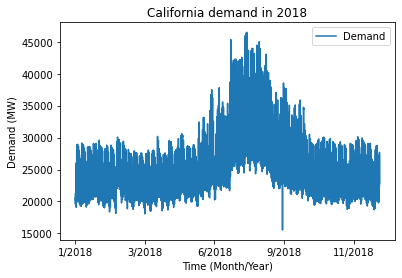

In [30]:
df_plot_demand_for_one_year = d.plot_demand_for_one_year(2018, file_name=None, save=False)
#TEST start
global demandTemporal
demandTemporal = 1
#TEST end

In [31]:
df_plot_demand_for_one_year

,Date,Demand
1,1/1/2018 12:00:00 AM,21202.0
12,1/1/2018 1:00:00 AM,20559.0
23,1/1/2018 2:00:00 AM,20017.0
34,1/1/2018 3:00:00 AM,19629.0
45,1/1/2018 4:00:00 AM,19613.0
...,...,...
116084,12/31/2018 7:00:00 PM,26814.0
116098,12/31/2018 8:00:00 PM,25905.0
116112,12/31/2018 9:00:00 PM,24935.0
116126,12/31/2018 10:00:00 PM,23804.0


<Figure size 432x288 with 0 Axes>

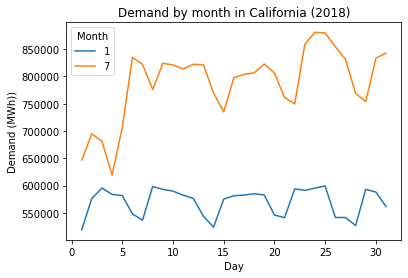

In [32]:
months = [1, 7]
df_plot_demand_by_month = d.plot_demand_by_month(2018, months)

In [33]:
df_plot_demand_by_month

Month,1,7
Day,,
1,518503.0,646657.0
2,576266.0,694752.0
3,595332.0,681381.0
4,583683.0,619096.0
5,581511.0,706501.0
6,548030.0,835014.0
7,536375.0,822258.0
8,598134.0,775988.0
9,592934.0,824279.0


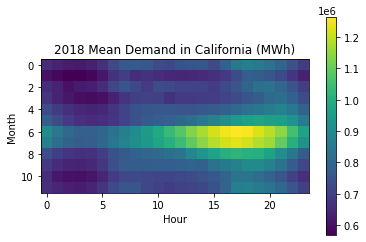

In [34]:
df_demand_month_hour_heatmap = d.plot_demand_month_hour_heatmap(2018, file_name=None, save=False)

In [35]:
df_demand_month_hour_heatmap

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Month,,,,,,,,,,,,,,,,,,,,,
1,657073.0,636725.0,623776.0,619879.0,631048.0,664529.0,723526.0,759200.0,762389.0,757922.0,...,752573.0,731569.0,780855.0,847242.0,868476.0,853277.0,831071.0,794612.0,742457.0,691576.0
2,602529.0,582881.0,571525.0,569215.0,580629.0,614896.0,669872.0,693871.0,660111.0,671241.0,...,654046.0,664267.0,683031.0,728358.0,779202.0,772915.0,755361.0,723751.0,676613.0,632993.0
3,661052.0,637821.0,604121.0,618986.0,627789.0,658118.0,714370.0,749379.0,722687.0,692665.0,...,707558.0,689915.0,725803.0,752004.0,793077.0,826572.0,828092.0,797917.0,747901.0,696126.0
4,674688.0,638893.0,614621.0,598696.0,592982.0,601297.0,632506.0,676693.0,700018.0,703664.0,...,688576.0,696119.0,709236.0,728210.0,749802.0,773131.0,807308.0,820537.0,785260.0,729281.0
5,730871.0,690872.0,663343.0,645732.0,639098.0,647998.0,676438.0,712191.0,743732.0,754527.0,...,759243.0,769062.0,784974.0,807015.0,827399.0,842070.0,859702.0,880226.0,850717.0,790417.0
6,778111.0,727228.0,691994.0,668014.0,656232.0,661416.0,682422.0,709155.0,740954.0,762424.0,...,847845.0,878676.0,911626.0,941750.0,963932.0,973115.0,963149.0,955137.0,922858.0,852684.0
7,895562.0,843953.0,807872.0,785686.0,783191.0,801551.0,827998.0,866489.0,906463.0,946958.0,...,1175878.0,1217324.0,1247760.0,1262854.0,1255146.0,1222320.0,1192038.0,1143019.0,1057094.0,967586.0
8,867413.0,820445.0,789359.0,773644.0,776319.0,804419.0,842209.0,877731.0,910087.0,940327.0,...,1142510.0,1185880.0,1218744.0,1230742.0,1215690.0,1183066.0,1160318.0,1097483.0,1006648.0,923746.0
9,732315.0,697886.0,673929.0,662529.0,668194.0,695634.0,741094.0,765540.0,783406.0,797862.0,...,932743.0,974179.0,1005849.0,1020132.0,1009128.0,1003138.0,972070.0,913001.0,840711.0,774522.0


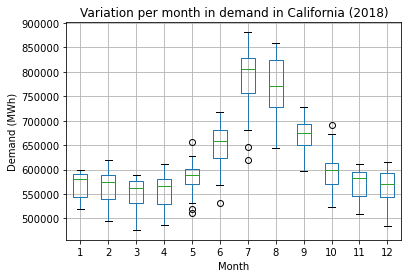

In [36]:
df_demand_variance = d.plot_demand_variance(2018, file_name=None, save=False)

In [37]:
df_demand_variance

Month,1,2,3,4,5,6,7,8,9,10,11,12
Day,,,,,,,,,,,,
1,518503.0,583065.0,589278.0,487232.0,584049.0,598345.0,646657.0,847840.0,649793.0,690715.0,603289.0,551248.0
2,576266.0,584708.0,583884.0,558731.0,586404.0,608250.0,694752.0,831685.0,628589.0,673758.0,611799.0,537163.0
3,595332.0,528907.0,536653.0,567100.0,578934.0,621709.0,681381.0,829315.0,652278.0,656131.0,563243.0,590519.0
4,583683.0,516738.0,514577.0,579709.0,611951.0,667902.0,619096.0,771652.0,713643.0,634245.0,544407.0,604699.0
5,581511.0,561771.0,570027.0,580733.0,579949.0,635302.0,706501.0,734950.0,714518.0,617996.0,609571.0,616341.0
6,548030.0,565707.0,567537.0,578400.0,548241.0,626307.0,835014.0,825291.0,695140.0,563063.0,583111.0,613236.0
7,536375.0,582697.0,569524.0,530126.0,606581.0,626514.0,822258.0,839200.0,728903.0,544832.0,586078.0,589878.0
8,598134.0,581514.0,541444.0,507141.0,622574.0,644439.0,775988.0,837254.0,709491.0,614749.0,579264.0,548632.0
9,592934.0,570955.0,560853.0,598146.0,626754.0,601454.0,824279.0,858680.0,675659.0,615535.0,577965.0,542552.0


In [38]:
#TEST start
with open('demandVars.pkl', 'wb') as f:
    pickle.dump([zoneCheck_ref, zoneCheck, yearCheck_ref, yearCheck, demandTemporal], f)
#TEST end

# Energy Visualization

In [39]:
# Demand Visualization Class
import Energy_Analysis as EA
import matplotlib.pyplot as plt
import pickle #TEST

In [40]:
#California average energy use: ~29 GWh per hour
#California average power: 29 GW
#Using capacity factor of 25%, Solar capacity needs to be at least 116 GW
#using 1.5 times needed solar, we have 164 GW
#24 hours of storage is 696 GWh
#https://www.energy.gov/sites/prod/files/2015/05/f22/CA-Energy%20Sector%20Risk%20Profile.pdf
test_supply = EA.EnergySupplyAnalysisCSV(164000)
test_demand = EA.EnergyDemandAnalysis()
test_storage = EA.StorageAnalysis(test_supply.getEnergySupply(), test_demand.getEnergyDemand(), 696000)
#print(test_storage.demand)
#print(test_storage.supply)
#pd.set_option("display.max_rows",100)
results = test_storage.get_storage_data()
test_storage.get_storage_data()
    


#https://assessingsolar.org/notebooks/solar_power_modeling.html

/home/arbera/private/ECE143/ProjectFinal/ECE143-Team13/notebooks/Energy_Analysis.py:82: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['Date'])
/home/arbera/private/ECE143/ProjectFinal/ECE143-Team13/notebooks/Energy_Analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['Date'])


,Year,Month,Day,Hour,Total Demand,Solar Supply,Storage Demand,Storage Supplied,Storage Left,Curtailed Supply,Total Supplied
0,2018,1,1,0,21202.0,4100.0,17102.0,17102.0,678898.0,0.0,21202.0
1,2018,1,1,1,20559.0,0.0,20559.0,20559.0,658339.0,0.0,20559.0
2,2018,1,1,2,20017.0,0.0,20017.0,20017.0,638322.0,0.0,20017.0
3,2018,1,1,3,19629.0,0.0,19629.0,19629.0,618693.0,0.0,19629.0
4,2018,1,1,4,19613.0,0.0,19613.0,19613.0,599080.0,0.0,19613.0
...,...,...,...,...,...,...,...,...,...,...,...
26275,2020,12,31,19,21279.0,83476.0,-62197.0,-62197.0,148834.0,0.0,21279.0
26276,2020,12,31,20,22489.0,84788.0,-62299.0,-62299.0,211133.0,0.0,22489.0
26277,2020,12,31,21,24493.0,76096.0,-51603.0,-51603.0,262736.0,0.0,24493.0
26278,2020,12,31,22,26594.0,58384.0,-31790.0,-31790.0,294526.0,0.0,26594.0


<Figure size 576x360 with 0 Axes>

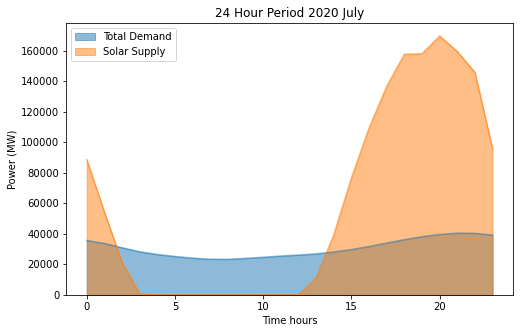

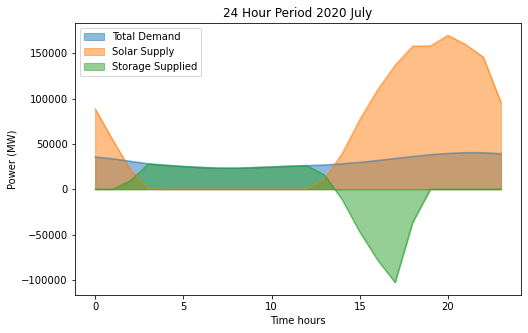

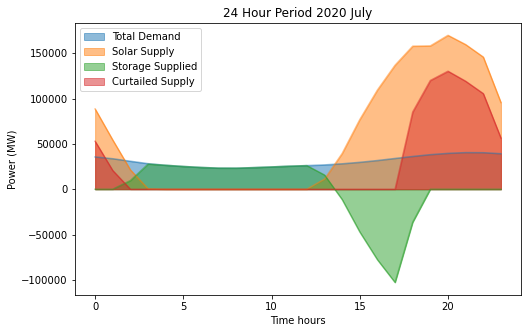

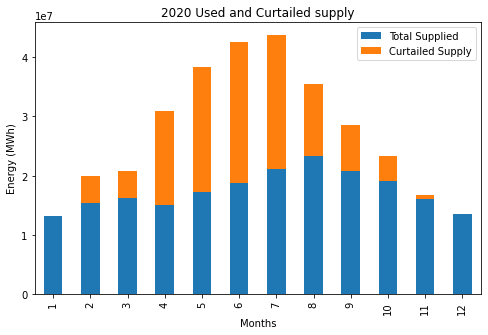

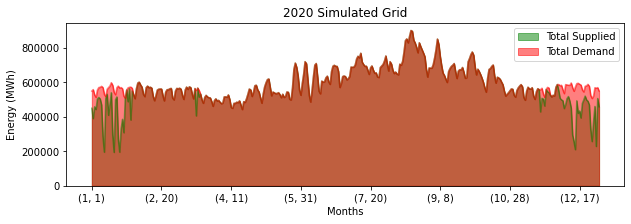

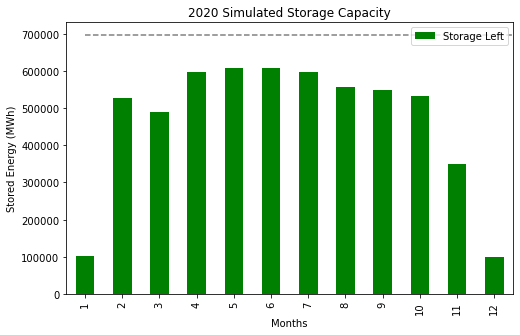

In [41]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.figure()

#Getting datasets
#TEST start
global analysisYear_ref
analysisYear_ref = 2020
results_2020 = results.loc[results['Year'] == analysisYear_ref]

global analysisYear
analysisYear = results_2020['Year'].iloc[0]
#TEST end

results_July_2020 = results_2020.loc[results['Month'] == 7]
results_July_10_2020 = results_July_2020.loc[results_July_2020["Day"] == 10]
results_monthly = results_2020.groupby([ "Month"]).sum()
results_daily = results_2020.groupby(["Month", "Day"]).sum()
results_monthly_mean = results_2020.groupby(["Month"]).mean()
results_daily_mean = results_2020.groupby(["Month", "Day"]).mean()


#plotting
results_July_10_2020.plot(x ="Hour", y=["Total Demand", "Solar Supply", ], kind="area", stacked=False)
plt.xlabel('Time hours')
plt.ylabel('Power (MW)')
plt.title('24 Hour Period 2020 July')
#TEST start
global hours24_1
hours24_1 = 1
#TEST end

results_July_10_2020.plot(x ="Hour", y=["Total Demand", "Solar Supply", "Storage Supplied"], kind="area", stacked=False)
plt.xlabel('Time hours')
plt.ylabel('Power (MW)')
plt.title('24 Hour Period 2020 July')
#TEST start
global hours24_2
hours24_2 = 1
#TEST end

results_July_10_2020.plot(x ="Hour", y=["Total Demand", "Solar Supply", "Storage Supplied","Curtailed Supply"], kind="area", stacked=False)
plt.xlabel('Time hours')
plt.ylabel('Power (MW)')
plt.title('24 Hour Period 2020 July')
#TEST start
global hours24_3
hours24_3 = 1
#TEST end

results_monthly.plot( y=["Total Supplied", 'Curtailed Supply'], kind="bar", stacked=True)
plt.xlabel('Months')
plt.ylabel('Energy (MWh)')
plt.title('2020 Used and Curtailed supply')
#TEST start
global used_curtailed
used_curtailed = 1
#TEST end

results_daily.plot(y=["Total Supplied", 'Total Demand'], kind="area", stacked=False, color=["green", "red"], figsize=(10,3))
plt.xlabel('Months')
plt.ylabel('Energy (MWh)')
plt.title('2020 Simulated Grid')
#TEST start
global grid
grid = 1
#TEST end

results_monthly_mean.plot(y="Storage Left", kind="bar", color="green")
plt.hlines(696000, xmin=0, xmax=12, linestyles='dashed',colors='grey', label='Maximum storage level')
plt.xlabel('Months')
plt.ylabel('Stored Energy (MWh)')
plt.title('2020 Simulated Storage Capacity')
#TEST start
global storageCapacity
storageCapacity = 1
#TEST end

In [42]:
#TEST start
with open('analysisVars.pkl', 'wb') as f:
    pickle.dump([analysisYear_ref, analysisYear, hours24_1, hours24_2, hours24_3, used_curtailed, grid, storageCapacity], f)
#TEST end

# Functionality and Coverage Testing

In [43]:
#####Supply Visualizations Check#####

In [44]:
%%file ./tests/test_1_supply.py

import pytest
import pickle
import os

with open('supplyVars.pkl', 'rb') as f:
    stateName, stateName_ref, allGhiHeatmap, stateGhiHeatmap, oneCoordGhi, stateGHIInOneYear, stateMonthHourHeatmap, stateVariance, stateGHIByMonth, inputCoord, nearestCoord = pickle.load(f)
    
def test_stateNameCheck():
    assert stateName == stateName_ref

def test_coordinateCheck():
    assert abs(inputCoord[0] - nearestCoord[0]) <= 1
    assert abs(inputCoord[1] - nearestCoord[1]) <= 1
    
def test_plotsCheck():
    assert allGhiHeatmap == 1
    assert stateGhiHeatmap == 1
    assert oneCoordGhi == 1
    assert stateGHIInOneYear == 1
    assert stateMonthHourHeatmap == 1
    assert stateVariance == 1
    assert stateGHIByMonth == 1

Overwriting ./tests/test_1_supply.py


In [45]:
#####Demand Visualizations Check#####

In [46]:
%%file ./tests/test_2_demand.py

import pytest
import pickle

with open('demandVars.pkl', 'rb') as f:
    zoneCheck_ref, zoneCheck, yearCheck_ref, yearCheck, demandTemporal = pickle.load(f)
    
def test_zoneCheck():
    assert zoneCheck_ref == zoneCheck
    
def test_yearCheck():
    assert yearCheck_ref == yearCheck

def test_plotsCheck():
    assert demandTemporal == 1

Overwriting ./tests/test_2_demand.py


In [47]:
#####Energy Analysis Check#####

In [48]:
%%file ./tests/test_3_analysis.py

import pytest
import pickle

with open('analysisVars.pkl', 'rb') as f:
    analysisYear_ref, analysisYear, hours24_1, hours24_2, hours24_3, used_curtailed, grid, storageCapacity = pickle.load(f)
    
def test_analysisYearCheck():
    assert analysisYear_ref == analysisYear

def test_plotsCheck():
    assert hours24_1 == 1
    assert hours24_2 == 1
    assert hours24_3 == 1
    assert used_curtailed == 1
    assert grid == 1
    assert storageCapacity == 1

Overwriting ./tests/test_3_analysis.py


In [49]:
!python3 -m pytest --cov=./tests -vv

============================= test session starts ==============================
platform linux -- Python 3.9.5, pytest-7.4.2, pluggy-1.3.0 -- /opt/conda/bin/python3
cachedir: .pytest_cache
rootdir: /home/arbera/private/ECE143/ProjectFinal/ECE143-Team13/notebooks
plugins: cov-4.1.0, anyio-3.2.1
collected 8 items                                                              

tests/test_1_supply.py::test_stateNameCheck PASSED                       [ 12%]
tests/test_1_supply.py::test_coordinateCheck PASSED                      [ 25%]
tests/test_1_supply.py::test_plotsCheck PASSED                           [ 37%]
tests/test_2_demand.py::test_zoneCheck PASSED                            [ 50%]
tests/test_2_demand.py::test_yearCheck PASSED                            [ 62%]
tests/test_2_demand.py::test_plotsCheck PASSED                           [ 75%]
tests/test_3_analysis.py::test_analysisYearCheck PASSED                  [ 87%]
tests/test_3_analysis.py::test_plotsCheck PASSED               